In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Conv1D, MaxPooling1D, LSTM
from tensorflow.keras.layers import Bidirectional, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Cargar datos estructurados
import h5py
import numpy as np

# Abrir archivo .mat versión 7.3
with h5py.File("tot_data.mat", "r") as f:
    # El nombre de la variable puede variar; usamos 'x' como nombre real detectado en tu archivo
    raw_data = f['x'][:]  # Esto da forma (7, 511700)

# Transponer para tener la forma correcta (511700, 7)


# Columnas relevantes
time = raw_data[:, 0]
freq = raw_data[:, 1]
rocof = raw_data[:, 2]
perturbation = raw_data[:, 3]
inertia = raw_data[:, 4]


In [6]:
# Crear secuencias por bloques de inercia
window_size = 100
step_size = 1
X_all, y_all = [], []

unique_inertias = np.unique(inertia)
for val in unique_inertias:
    mask = inertia == val
    freq_block = freq[mask]
    rocof_block = rocof[mask]
    y_block = inertia[mask]

    for i in range(0, len(freq_block) - window_size, step_size):
        X_seq = np.stack([freq_block[i:i+window_size], rocof_block[i:i+window_size]], axis=1)
        X_all.append(X_seq)
        y_all.append(y_block[i + window_size])

X_all = np.array(X_all)
y_all = np.array(y_all)

# División temporal
stratify_labels = y_all.flatten()

# Dividir los datos manteniendo proporciones de inercia
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.2, stratify=stratify_labels, random_state=42
)


In [10]:
def train_and_plot(model, model_name):
    model.compile(optimizer='adam', loss='mae')
    early_stop = EarlyStopping(patience=3, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=50, batch_size=64,
                        validation_split=0.2, verbose=0, callbacks=[early_stop])
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    print(f"{model_name} MAE: {mae:.4f}")

    plt.figure()
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f"{model_name} - Entrenamiento")
    plt.xlabel("Epoch")
    plt.ylabel("MAE")
    plt.legend()
    plt.grid(True)

    # 🧮 Mostrar MAE en recuadro
    mae_val_final = history.history['val_loss'][-1]
    plt.text(0.95, 0.95,
             f"MAE final: {mae_val_final:.4f}",
             transform=plt.gca().transAxes,
             fontsize=10,
             verticalalignment='top',
             horizontalalignment='right',
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))

    # 💾 Guardar como archivo
    plt.savefig(f"{model_name.replace(' ', '_')}.png", dpi=300, bbox_inches='tight')
    plt.show()

3188/3188 ━━━━━━━━━━━━━━━━━━━━ 1s 380us/step
Simple MAE: 0.3391


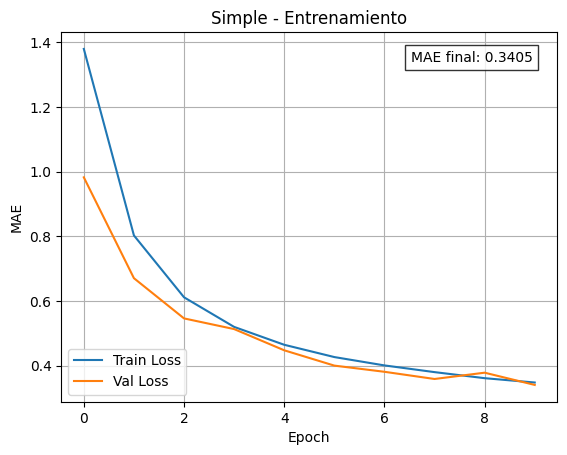

In [5]:
model_simple = Sequential([
    Input(shape=(window_size, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])
train_and_plot(model_simple, "Simple")


3188/3188 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
CNN (kernels=3+2) MAE: 0.2057


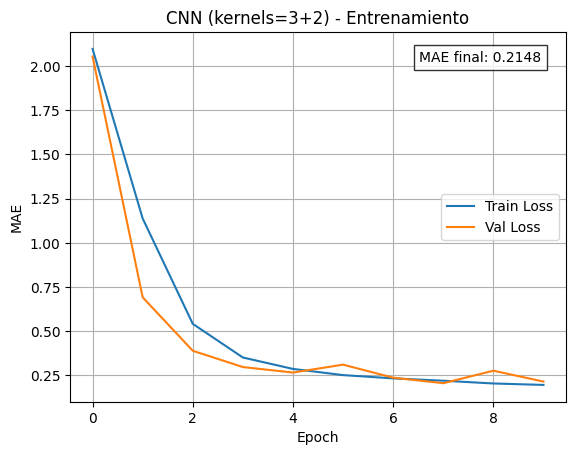

3188/3188 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
CNN (kernels=5+3) MAE: 0.2452


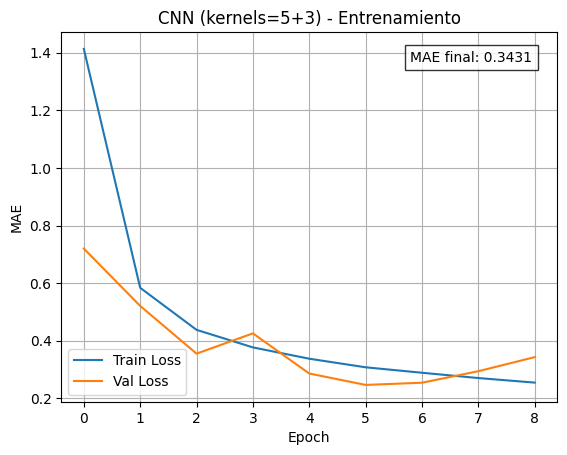

3188/3188 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
CNN (kernels=7+5) MAE: 0.1414


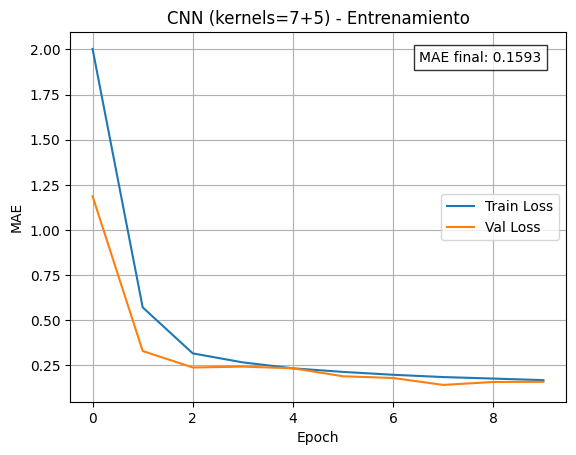

In [ ]:
for k1, k2 in [(3, 2), (5, 3), (7, 5)]:
    model_cnn = Sequential([
        Input(shape=(window_size, 2)),
        Conv1D(64, kernel_size=k1, activation='relu'),
        Conv1D(32, kernel_size=k2, activation='relu'),
        MaxPooling1D(),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(1)
    ])
    train_and_plot(model_cnn, f"CNN (kernels={k1}+{k2})")


3188/3188 ━━━━━━━━━━━━━━━━━━━━ 83s 26ms/step
LSTM Stack 64+32 con window size 60 MAE: 0.2906


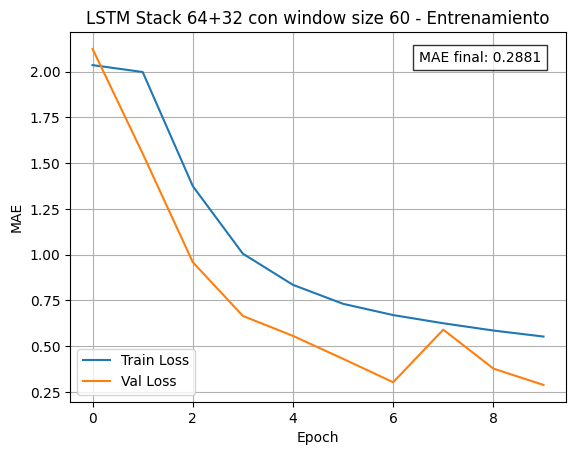

KeyboardInterrupt: 

In [4]:
for window_size in [60,100, 140]:#0.3s ,0.5s y 0.7s
    model_lstm = Sequential([
        Input(shape=(window_size, 2)),
        Bidirectional(LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.2)),
        LayerNormalization(),
        Bidirectional(LSTM(32, dropout=0.2, recurrent_dropout=0.2)),
        Dense(64, activation='relu'),
        Dense(1)
    ])
    train_and_plot(model_lstm, f"LSTM Stack {64}+{32} con window size {window_size}")


3188/3188 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step
Híbrido CNN-LSTM 3+2,100 mejorado  MAE: 0.1290


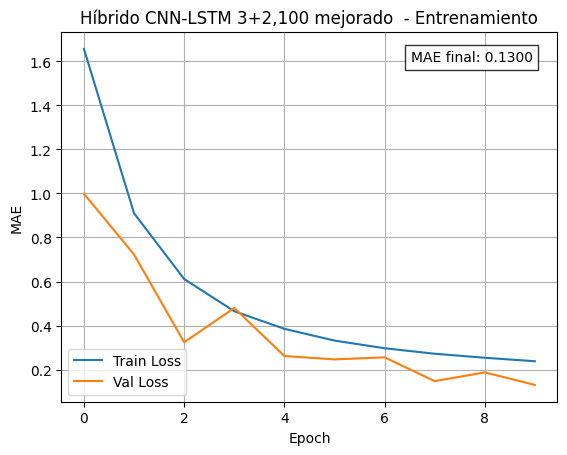

3188/3188 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step
Híbrido CNN-LSTM 5+3,100 mejorado  MAE: 0.1122


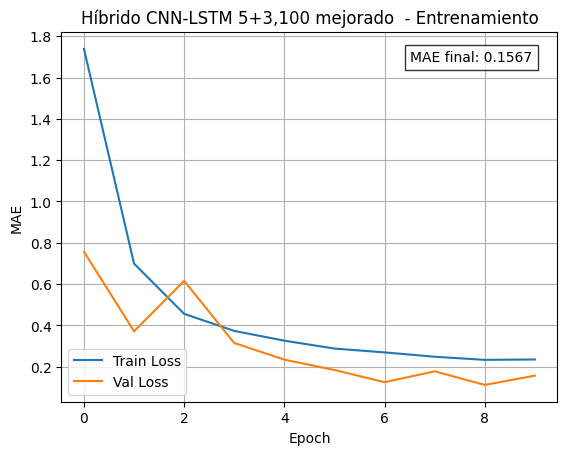

3188/3188 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step
Híbrido CNN-LSTM 7+5,100 mejorado  MAE: 0.2026


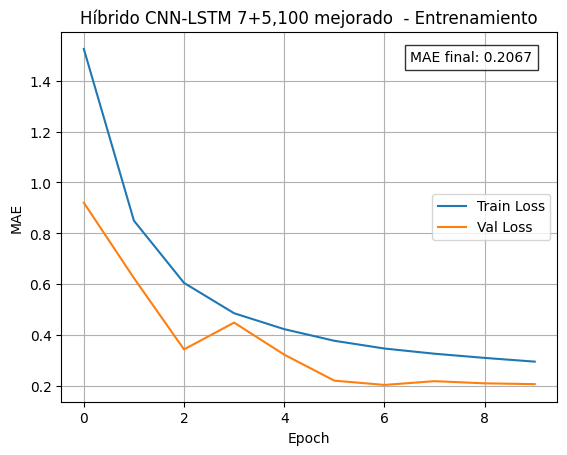

In [10]:
window_size=100
for k1, k2 in [(3, 2), (5, 3), (7, 5)]:
    model_hybrid = Sequential([
        Input(shape=(window_size, 2)),

        # Primera capa convolucional
        Conv1D(64, kernel_size=k1, activation='relu'),
        MaxPooling1D(),

        # Segunda capa convolucional (más pequeña)
        Conv1D(32, kernel_size=k2, activation='relu'),
        MaxPooling1D(),

        # Capa LSTM más compleja
        LSTM(64, dropout=0.3, recurrent_dropout=0.2),

        # Capa densa intermedia
        Dense(64, activation='relu'),

        # Capa de salida
        Dense(1)
    ])
    train_and_plot(model_hybrid, f"Híbrido CNN-LSTM {k1}+{k2},{window_size} mejorado ")


3188/3188 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
CNN prueba mayor n neuronas y epocas y tan en densa(kernels=3+2+2) MAE: 0.0997


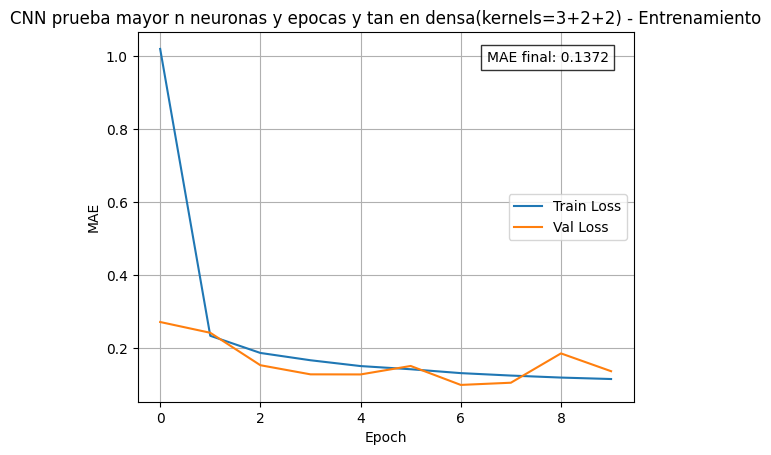

3188/3188 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
CNN prueba mayor n neuronas y epocas y tan en densa(kernels=5+3+2) MAE: 0.0650


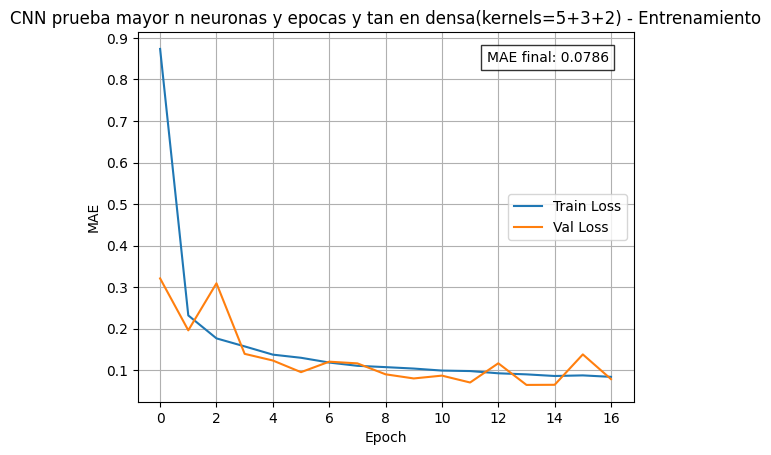

3188/3188 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
CNN prueba mayor n neuronas y epocas y tan en densa(kernels=7+5+3) MAE: 0.0630


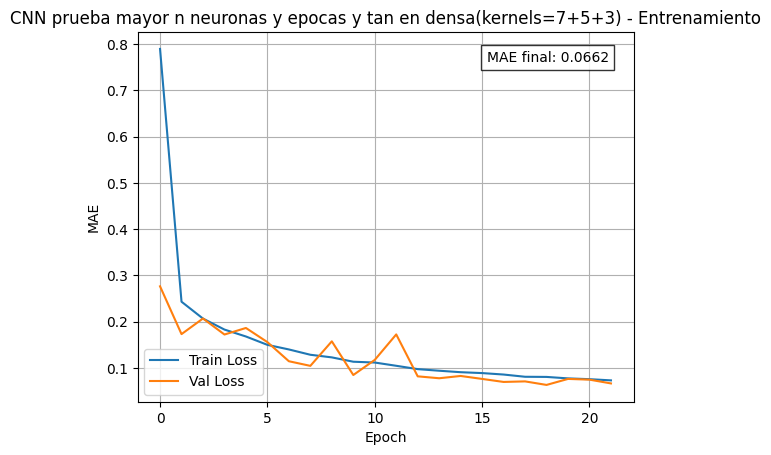

3188/3188 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step
CNN prueba mayor n neuronas y epocas y tan en densa(kernels=9+7+5) MAE: 0.0809


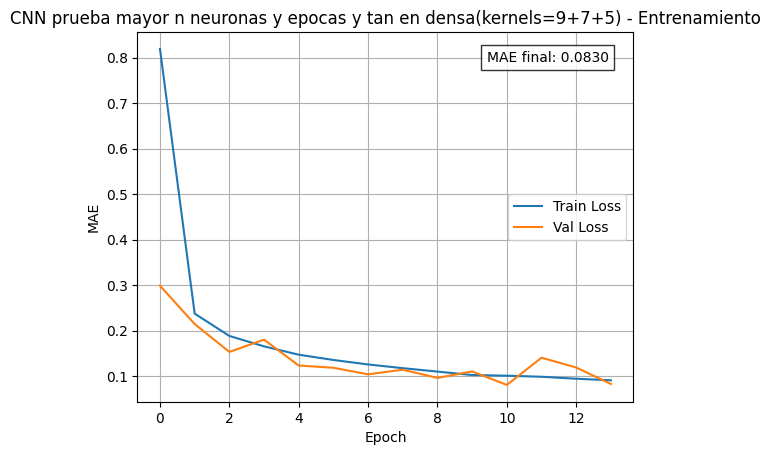

In [13]:
for k1, k2,k3 in [(3, 2, 2), (5, 3,2 ), (7, 5, 3),(9 , 7, 5)]:
    model_cnn = Sequential([
        Input(shape=(window_size, 2)),
        Conv1D(128, kernel_size=k1, activation='relu'),
        Conv1D(64, kernel_size=k2, activation='relu'),
        Conv1D(32, kernel_size=k2, activation='relu'),
        MaxPooling1D(),
        Flatten(),
        Dense(128, activation='tanh'),
        Dense(64, activation='tanh'),
        Dense(1)
    ])
    train_and_plot(model_cnn, f"CNN prueba mayor n neuronas y epocas y tan en densa(kernels={k1}+{k2}+{k3})")
